In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

# eager execution
tf.enable_eager_execution()

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.set_random_seed(777)

# MNIST /Fashion MNIST
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# convert input images to number in range 0~1
train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.
# one hot encoding label
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# image dataset to tensor
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size)

print('train_images shape: {0}, test_images shape: {1}'.format(train_images.shape, test_images.shape))


def create_model():
  model = keras.Sequential()
  #units 차원... 왜 128인지..
  model.add(keras.layers.CuDNNLSTM(units=128, input_shape=(28,28)))
  #Fully connected layer, 최종 출력을 10개로 줄인다
  model.add(keras.layers.Dense(units=10))
  return model

def loss_fn(model, images, labels):
  logits = model(images, training=True)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
  return loss

def grad(model, images, labels):
  with tf.GradientTape() as tape:
    loss = loss_fn(model, images, labels)
  return tape.gradient(loss, model.variables)

def evaluate(model, images, labels):
  logits = model(images, training=True)
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return accuracy

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

1.13.1
2.2.4-tf
train_images shape: (60000, 28, 28), test_images shape: (10000, 28, 28)


In [0]:
model = create_model()
model.summary()

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# training
print('Learining started.')
for epoch in range(training_epochs):
  avg_loss = 0.
  avg_train_acc = 0.
  avg_test_acc = 0.
  train_step = 0
  test_step = 0
  
  for images, labels in train_dataset:
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.variables))
    loss = loss_fn(model, images, labels)
    acc = evaluate(model, images, labels)
    avg_loss = avg_loss + loss
    avg_train_acc = avg_train_acc + acc
    train_step += 1
  avg_loss = avg_loss / train_step
  avg_train_acc = avg_train_acc / train_step
  
  for images, labels in test_dataset:
    acc = evaluate(model, images, labels)
    avg_test_acc = avg_test_acc + acc
    test_step += 1
  avg_test_acc = avg_test_acc / test_step
  
  print('Epoch: {0}, loss: {1}, train_accuracy: {2}, test_accuracy {3}'.format(epoch+1, avg_loss, avg_train_acc, avg_test_acc))
  
print('Learning Finished !!!!!')

  

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 128)               80896     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 82,186
Trainable params: 82,186
Non-trainable params: 0
_________________________________________________________________
Learining started.
Epoch: 1, loss: 0.45745280385017395, train_accuracy: 0.8567673563957214, test_accuracy 0.9469001889228821
Epoch: 2, loss: 0.11979957669973373, train_accuracy: 0.9652667045593262, test_accuracy 0.9711001515388489
Epoch: 3, loss: 0.07639145106077194, train_accuracy: 0.9773162007331848, test_accuracy 0.9766003489494324
Epoch: 4, loss: 0.054129861295223236, train_accuracy: 0.9847649335861206, test_accuracy 0.9785003662109375
Epoch: 5, loss: 0.

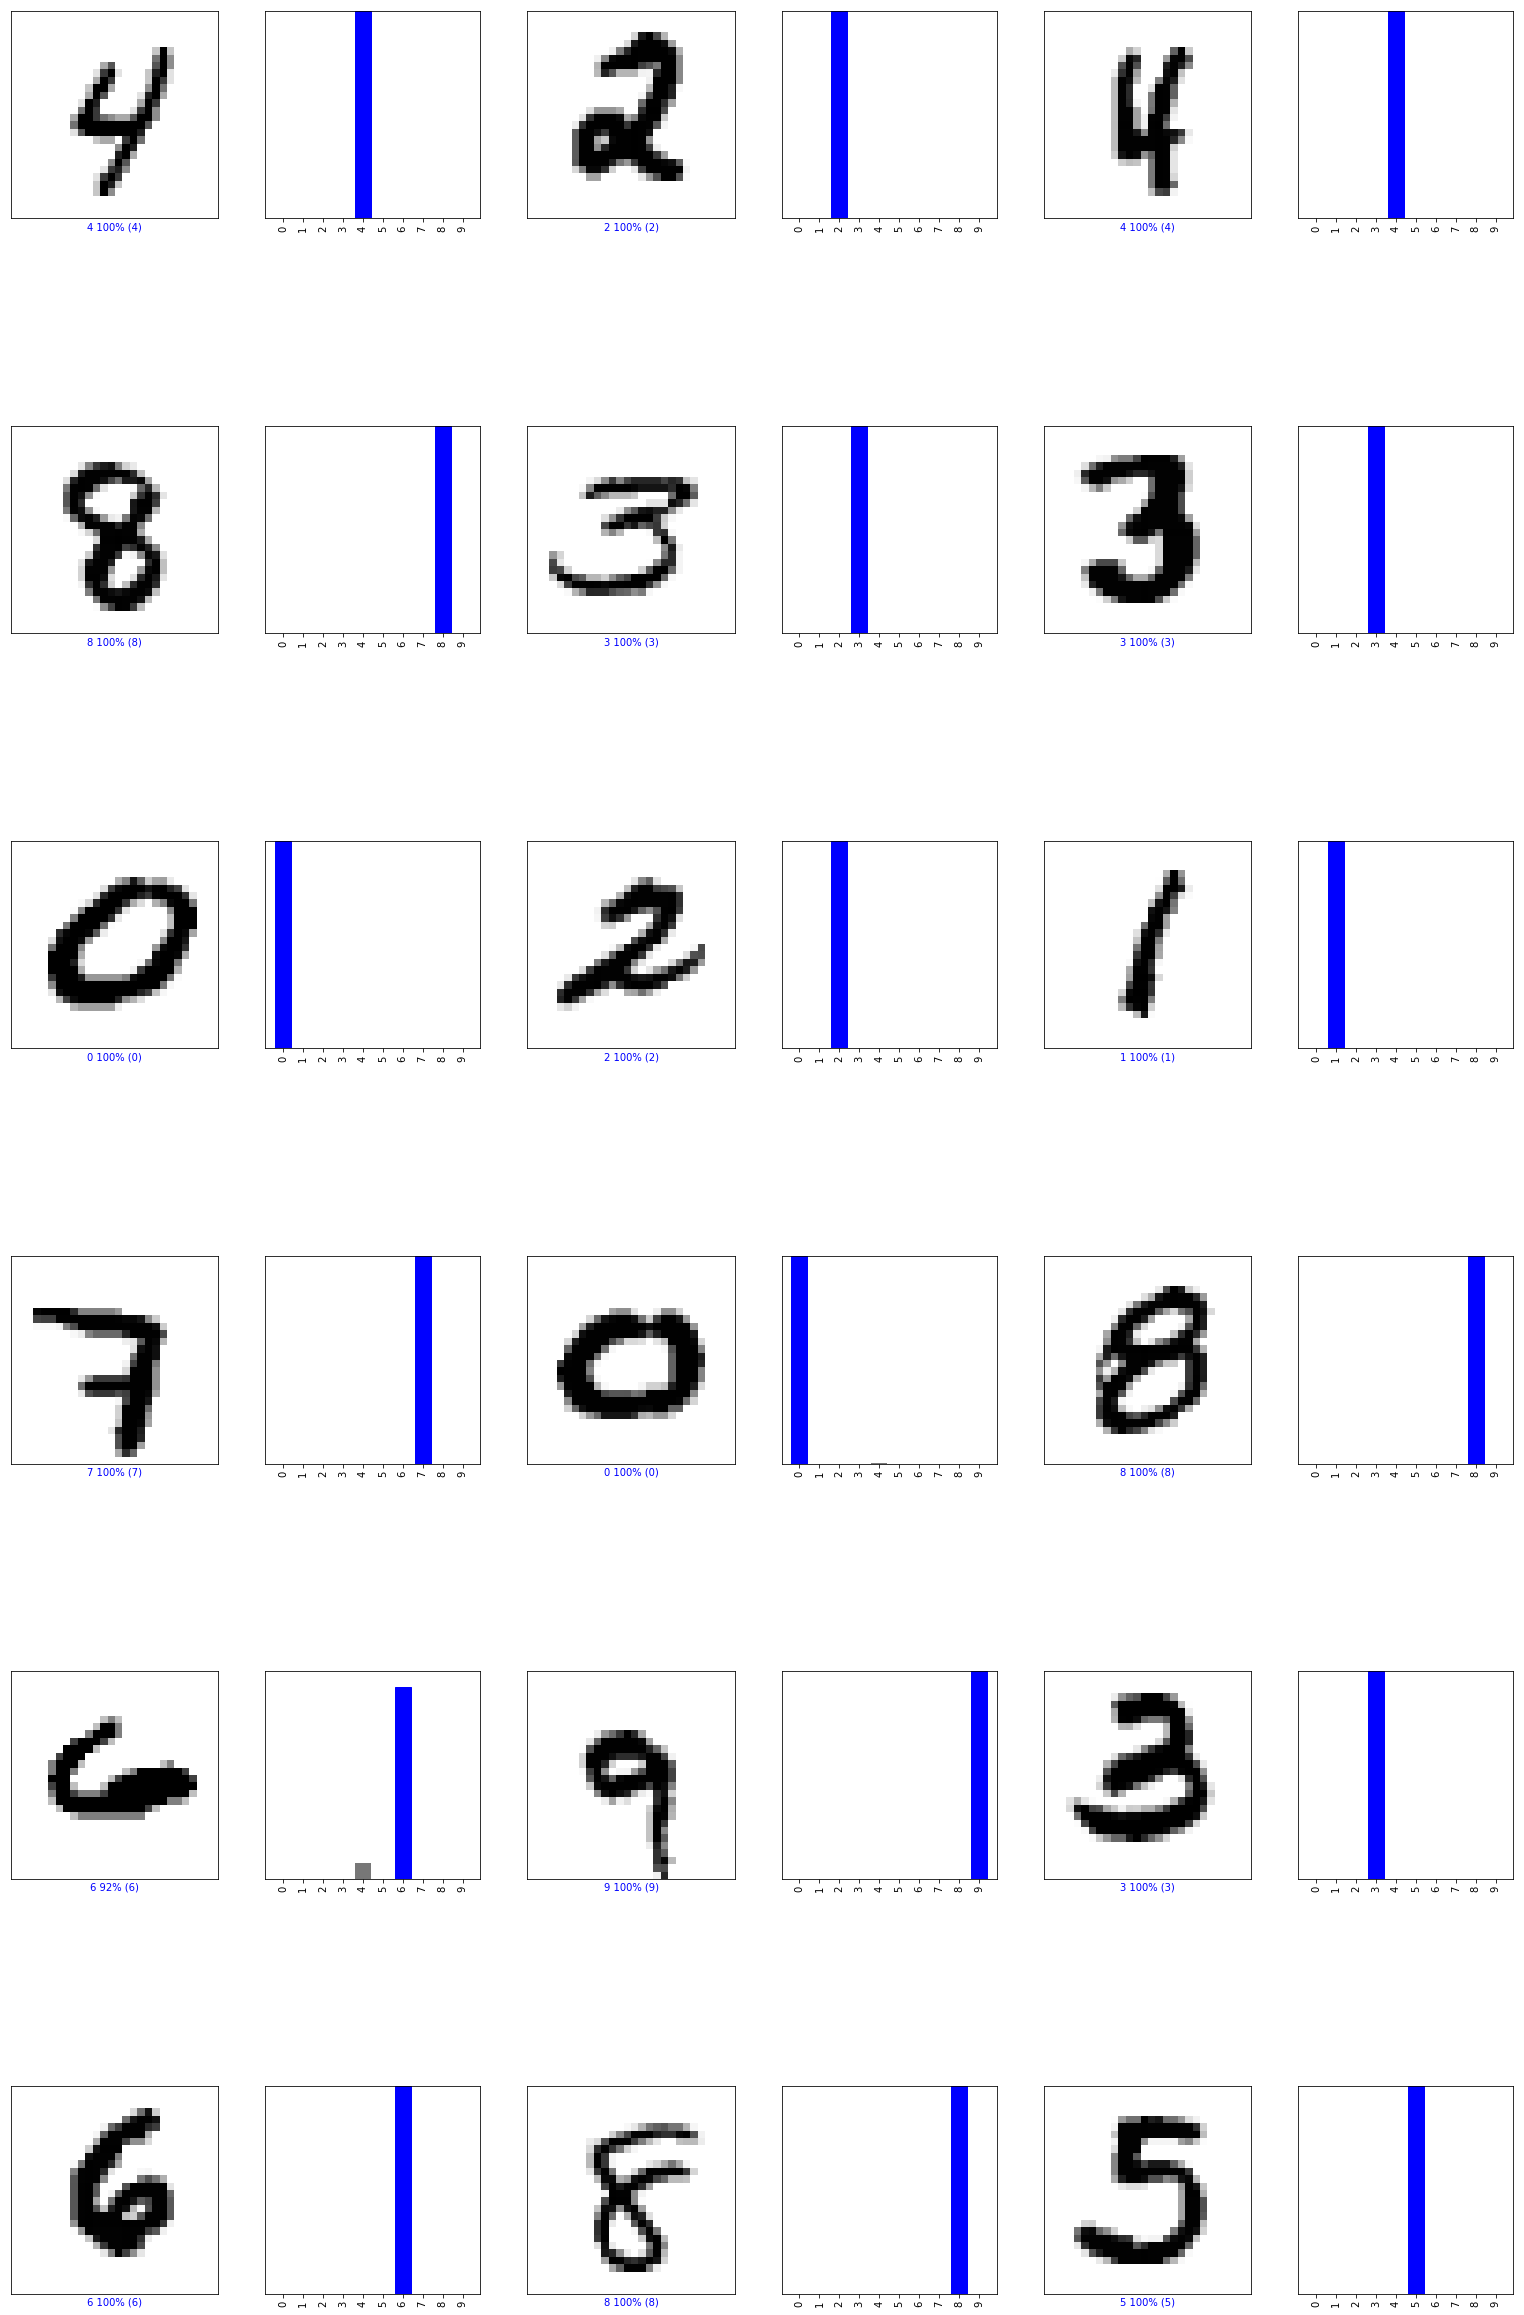

In [0]:
n_test = 10000
n_class = 10
rnd_idx = np.random.randint(1, n_test//(batch_size))
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = keras.activations.softmax(model(images, training=False))    
    num_rows = 6
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*3*num_cols, 7*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break